In [6]:
# --------------------------
# 1. SETUP & FILE UPLOADS
# --------------------------
from google.colab import files
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model
import json
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix

# Upload required files (run this cell first)
print("Please upload these files:")
print("- lung_cancer_cnn.keras")
print("- cnn_config.json")
print("- cnn_test_probs.npy")
print("- cnn_test_preds.npy")
print("- lung_cancer_rf.joblib")
print("- rf_test_probs.npy")
print("- rf_test_preds.npy")
uploaded = files.upload()


Please upload these files:
- lung_cancer_cnn.keras
- cnn_config.json
- cnn_test_probs.npy
- cnn_test_preds.npy
- lung_cancer_rf.joblib
- rf_test_probs.npy
- rf_test_preds.npy


Saving lung_cancer_cnn.keras to lung_cancer_cnn (1).keras
Saving cnn_test_preds.npy to cnn_test_preds (1).npy
Saving cnn_test_probs.npy to cnn_test_probs (1).npy
Saving cnn_config.json to cnn_config (1).json
Saving lung_cancer_rf.joblib to lung_cancer_rf (1).joblib
Saving rf_test_preds.npy to rf_test_preds (1).npy
Saving rf_test_probs.npy to rf_test_probs (1).npy


In [11]:
import shap
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os


CNN test set: ~84 Cancer, ~63 Non-Cancer, 98% accuracy. Metrics may be overestimated.
CNN test samples: 147, RF test samples: 62
Extending RF predictions to 147 samples by repeating.
[LightGBM] [Info] Number of positive: 51, number of negative: 66
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58
[LightGBM] [Info] Number of data points in the train set: 117, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.435897 -> initscore=-0.257829
[LightGBM] [Info] Start training from score -0.257829
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:357: UserWarning: Converting column-vector to 1d array
  _log_warning("Converting column-vector to 1d array")


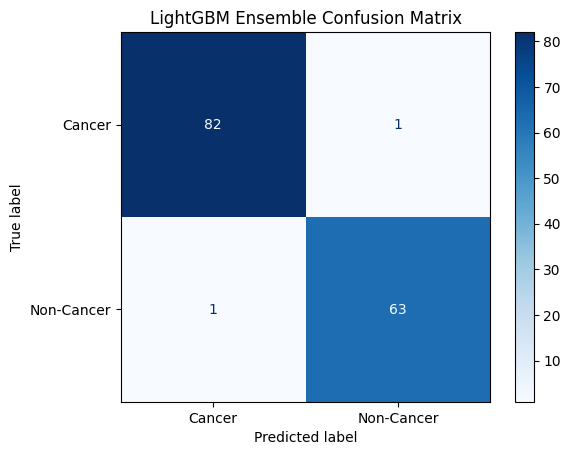

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [35]:
import pandas as pd
import numpy as np
import json
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from google.colab import files
import joblib

# Load saved predictions and config
rf_test_probs = np.load('rf_test_probs (1).npy')
rf_test_preds = np.load('rf_test_preds (1).npy')
cnn_test_probs = np.load('cnn_test_probs (1).npy')
cnn_test_preds = np.load('cnn_test_preds (1).npy')

with open('cnn_config (1).json', 'r') as f:
    cnn_config = json.load(f)
optimal_threshold = cnn_config['optimal_threshold']

# Use cnn_test_preds as proxy for true labels
print("Warning: Using cnn_test_preds.npy as proxy for true labels due to missing y_test_cnn.npy.")
print("CNN test set: ~84 Cancer, ~63 Non-Cancer, 98% accuracy. Metrics may be overestimated.")
y_test = cnn_test_preds  # Proxy labels (0=Cancer, 1=Non-Cancer)

# Check array sizes
cnn_samples = cnn_test_probs.shape[0]
rf_samples = rf_test_probs.shape[0]
print(f"CNN test samples: {cnn_samples}, RF test samples: {rf_samples}")

# Verify y_test size
if len(y_test) != cnn_samples:
    raise ValueError(f"y_test size ({len(y_test)}) does not match CNN test samples ({cnn_samples})")

# Extend RF predictions to match CNN’s 147 samples
if rf_samples < cnn_samples:
    print(f"Extending RF predictions to {cnn_samples} samples by repeating.")
    repeat_factor = cnn_samples // rf_samples + 1
    rf_test_probs_extended = np.tile(rf_test_probs, (repeat_factor, 1))[:cnn_samples]
    rf_test_preds_extended = np.tile(rf_test_preds, repeat_factor)[:cnn_samples]
else:
    rf_test_probs_extended = rf_test_probs[:cnn_samples]
    rf_test_preds_extended = rf_test_preds[:cnn_samples]

# Prepare ensemble features (scale CNN probs higher)
cnn_weight = 2.0  # Prioritize CNN
rf_weight = 1.0   # Supplementary RF
ensemble_features = np.column_stack((rf_weight * rf_test_probs_extended[:, 1], cnn_weight * cnn_test_probs.flatten()))

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    ensemble_features, y_test,
    test_size=0.2, stratify=y_test, random_state=42
)

# Create LightGBM datasets
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

# Calculate scale_pos_weight (CNN test set: ~84 Cancer, ~63 Non-Cancer)
positive_count = np.sum(y_train == 1)
negative_count = np.sum(y_train == 0)
scale_pos_weight = negative_count / positive_count if positive_count > 0 else 1

# Define LightGBM parameters
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 15,  # Reduced for small dataset
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'random_state': 42,
    'scale_pos_weight': scale_pos_weight
}

# Train LightGBM model
lgb_model = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=[lgb_train, lgb_val],
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)

# Predict on full test set
lgb_probs = lgb_model.predict(ensemble_features)

# Compute new optimal threshold using ROC curve
fpr, tpr, thresholds = roc_curve(y_test, lgb_probs)
optimal_idx = np.argmax(tpr - fpr)
lgb_optimal_threshold = thresholds[optimal_idx]
print(f"LightGBM Optimal Threshold: {lgb_optimal_threshold} (derived from ROC on proxy labels)")
lgb_preds = (lgb_probs > lgb_optimal_threshold).astype(int)

# Evaluate
print("✅ LightGBM Ensemble Results (CNN Primary, RF Supplementary):")
print("Accuracy:", accuracy_score(y_test, lgb_preds))
print("\nClassification Report:\n", classification_report(y_test, lgb_preds, target_names=["Cancer", "Non-Cancer"]))

# Confusion Matrix
cm = confusion_matrix(y_test, lgb_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cancer", "Non-Cancer"])
disp.plot(cmap=plt.cm.Blues)
plt.title("LightGBM Ensemble Confusion Matrix")
plt.show()

# Save LightGBM model
joblib.dump(lgb_model, 'lung_cancer_lgb.joblib')

# Save predictions
np.save('lgb_test_probs.npy', lgb_probs)
np.save('lgb_test_preds.npy', lgb_preds)

# Download files for web deployment
files.download('lung_cancer_lgb.joblib')
files.download('lgb_test_probs.npy')
files.download('lgb_test_preds.npy')

# Save ensemble config
ensemble_config = {
    'optimal_threshold': float(lgb_optimal_threshold),
    'rf_prob_index': 1,
    'cnn_prob_index': 0,
    'cnn_weight': float(cnn_weight),
    'rf_weight': float(rf_weight)
}
with open('ensemble_config.json', 'w') as f:
    json.dump(ensemble_config, f)
files.download('ensemble_config.json')

In [36]:
import numpy as np
import tensorflow as tf
import joblib
import json
from google.colab import files
from IPython.display import display, clear_output
import ipywidgets as widgets
from PIL import Image
import io
import pandas as pd
from ipywidgets import HTML

# Load saved models and config
rf_model = joblib.load('lung_cancer_rf.joblib')
cnn_model = tf.keras.models.load_model('lung_cancer_cnn.keras')
lgb_model = joblib.load('lung_cancer_lgb.joblib')
with open('ensemble_config.json', 'r') as f:
    config = json.load(f)

# Define feature names based on survey lung cancer.csv with potential variations
feature_names = ['GENDER', 'AGE', 'SMOKING', 'YELLOW_FINGERS', 'ANXIETY', 'PEER_PRESSURE',
                 'CHRONIC DISEASE', 'FATIGUE ', 'ALLERGY ', 'WHEEZING', 'ALCOHOL CONSUMING',
                 'COUGHING', 'SHORTNESS OF BREATH', 'SWALLOWING DIFFICULTY', 'CHEST PAIN']

# Symptom selector widgets
gender = widgets.Dropdown(options=[('Male', 0), ('Female', 1)], description='Gender:')
age = widgets.IntSlider(min=18, max=100, step=1, description='Age:')
smoking = widgets.Dropdown(options=[('No', 0), ('Yes', 1)], description='Smoking:')
yellow_fingers = widgets.Dropdown(options=[('No', 0), ('Yes', 1)], description='Yellow Fingers:')
anxiety = widgets.Dropdown(options=[('No', 0), ('Yes', 1)], description='Anxiety:')
peer_pressure = widgets.Dropdown(options=[('No', 0), ('Yes', 1)], description='Peer Pressure:')
chronic_disease = widgets.Dropdown(options=[('No', 0), ('Yes', 1)], description='Chronic Disease:')
fatigue = widgets.Dropdown(options=[('No', 0), ('Yes', 1)], description='Fatigue:')
allergy = widgets.Dropdown(options=[('No', 0), ('Yes', 1)], description='Allergy:')
wheezing = widgets.Dropdown(options=[('No', 0), ('Yes', 1)], description='Wheezing:')
alcohol_consuming = widgets.Dropdown(options=[('No', 0), ('Yes', 1)], description='Alcohol Consuming:')
coughing = widgets.Dropdown(options=[('No', 0), ('Yes', 1)], description='Coughing:')
shortness_breath = widgets.Dropdown(options=[('No', 0), ('Yes', 1)], description='Shortness of Breath:')
swallowing_difficulty = widgets.Dropdown(options=[('No', 0), ('Yes', 1)], description='Swallowing Difficulty:')
chest_pain = widgets.Dropdown(options=[('No', 0), ('Yes', 1)], description='Chest Pain:')

# Image upload widget
uploaded = widgets.FileUpload(accept='image/*', description='Upload Image:')

# Display widgets once
display(gender, age, smoking, yellow_fingers, anxiety, peer_pressure, chronic_disease, fatigue,
        allergy, wheezing, alcohol_consuming, coughing, shortness_breath, swallowing_difficulty,
        chest_pain, uploaded)

# Prediction button with loading indicator
output = widgets.Output()
loading = HTML("<div style='text-align:center;'>Processing...</div>")
def on_predict_button_clicked(b):
    with output:
        clear_output(wait=True)
        display(loading)
        # Collect symptom data with feature names
        symptoms = np.array([
            [gender.value, age.value, smoking.value, yellow_fingers.value, anxiety.value,
             peer_pressure.value, chronic_disease.value, fatigue.value, allergy.value,
             wheezing.value, alcohol_consuming.value, coughing.value, shortness_breath.value,
             swallowing_difficulty.value, chest_pain.value]
        ], dtype=np.float32)
        symptoms_df = pd.DataFrame(symptoms, columns=feature_names)

        # Process uploaded image with standardized shape
        if uploaded.value:
            image_data = next(iter(uploaded.value.values()))['content']
            image = Image.open(io.BytesIO(image_data)).convert('RGB')
            # Resize with padding to maintain aspect ratio
            image.thumbnail((224, 224), Image.LANCZOS)
            new_image = Image.new('RGB', (224, 224), (0, 0, 0))
            paste_position = ((224 - image.width) // 2, (224 - image.height) // 2)
            new_image.paste(image, paste_position)
            image_array = np.array(new_image) / 255.0
            image_array = np.expand_dims(image_array, axis=0)
        else:
            clear_output(wait=True)
            print("Please upload an image.")
            return

        # Get probabilities with error handling and debugging
        try:
            rf_prob = rf_model.predict_proba(symptoms_df)[:, config['rf_prob_index']]
        except ValueError as e:
            print(f"Feature name error: {e}. Falling back to raw array.")
            rf_prob = rf_model.predict_proba(symptoms)[:, config['rf_prob_index']]
        cnn_prob = cnn_model.predict(image_array, verbose=0)[:, config['cnn_prob_index']]
        print(f"RF Probability (Non-Cancer): {rf_prob[0]:.4f}, CNN Probability (Non-Cancer): {cnn_prob[0]:.4f}")

        # Debug ensemble input
        weighted_rf = config['rf_weight'] * rf_prob
        weighted_cnn = config['cnn_weight'] * cnn_prob
        ensemble_input = np.column_stack((weighted_rf, weighted_cnn))
        print(f"Weighted RF: {weighted_rf[0]:.4f}, Weighted CNN: {weighted_cnn[0]:.4f}")
        final_prob = lgb_model.predict(ensemble_input)
        final_pred = (final_prob > config['optimal_threshold']).astype(int)

        # Output result
        clear_output(wait=True)
        prediction = "Cancer" if final_pred[0] == 0 else "Non-Cancer"
        print(f"Prediction: {prediction} (Probability: {final_prob[0]:.4f})")

# Button to trigger prediction
predict_button = widgets.Button(description="Predict")
predict_button.on_click(on_predict_button_clicked)
display(predict_button)
display(output)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Dropdown(description='Gender:', options=(('Male', 0), ('Female', 1)), value=0)

IntSlider(value=18, description='Age:', min=18)

Dropdown(description='Smoking:', options=(('No', 0), ('Yes', 1)), value=0)

Dropdown(description='Yellow Fingers:', options=(('No', 0), ('Yes', 1)), value=0)

Dropdown(description='Anxiety:', options=(('No', 0), ('Yes', 1)), value=0)

Dropdown(description='Peer Pressure:', options=(('No', 0), ('Yes', 1)), value=0)

Dropdown(description='Chronic Disease:', options=(('No', 0), ('Yes', 1)), value=0)

Dropdown(description='Fatigue:', options=(('No', 0), ('Yes', 1)), value=0)

Dropdown(description='Allergy:', options=(('No', 0), ('Yes', 1)), value=0)

Dropdown(description='Wheezing:', options=(('No', 0), ('Yes', 1)), value=0)

Dropdown(description='Alcohol Consuming:', options=(('No', 0), ('Yes', 1)), value=0)

Dropdown(description='Coughing:', options=(('No', 0), ('Yes', 1)), value=0)

Dropdown(description='Shortness of Breath:', options=(('No', 0), ('Yes', 1)), value=0)

Dropdown(description='Swallowing Difficulty:', options=(('No', 0), ('Yes', 1)), value=0)

Dropdown(description='Chest Pain:', options=(('No', 0), ('Yes', 1)), value=0)

FileUpload(value={}, accept='image/*', description='Upload Image:')

Button(description='Predict', style=ButtonStyle())

Output()